<a href="https://colab.research.google.com/github/mtxslv/digitalprocessingsimulations/blob/master/band_stopFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importações

In [0]:
import numpy as np
import matplotlib.pyplot as plt # plotting loops

##Em primeiro lugar, vamos projetar nosso filtro...

Para a [janela de kaiser](https://docs.scipy.org/doc/numpy/reference/generated/numpy.kaiser.html), temos que beta = 3.395321052 e que M = 90. Também iremos utilizar funções [sinc](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sinc.html). Como np.sinc não permite resetarmos o valor de omega de corte, iremos definir a nossa própria sinc. Também iremos usar a função [impulso unitário](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.unit_impulse.html).

In [0]:
beta = 3.395321052
M = 90 # quantidade de coeficientes
N = M + 1 # quantidade de amostras 

In [0]:
def my_sinc(n, omega_c = 3.141592653589793): 
  '''
  input: array-like of domain elements and cut-off frequency (default = np.pi).
  output: array-like of sinus cardialis values.
  '''
  # if omega_c is not set by the user, my_sinc is equivalent to np.sinc. 
  import numpy as np
  ans = np.zeros(np.shape(n))
  for i in range(np.size(n)):
    #print(n[i])
    if n[i]==0:                 #is there a 0 in the domain?
      ans[i] = omega_c/np.pi # If there is a 0 in the domain, re-set its answer
    else:
      ans[i] = np.sin(omega_c*n[i])/(np.pi*n[i])
  return ans

In [0]:
def my_unit_pulse(n, shift=0): #delta[n-shift]
  '''
  input: array_like of domain elements and shift (to the left)
  output: delta function to each domain elements
  '''
  import numpy as np
  ans = np.zeros(np.size(n))
  shift = int(shift)
  ans[np.argwhere(n==0)+shift] = 1
  return ans

In [0]:
def h_rf(n, beta_kaiser, M_kaiser, omega_c_min, omega_c_max):
  '''
  input: array-like of domain values
  output: array-like of calculated values. Watch out! The answer is shifted by n.len/2 already.
  '''
  
  import numpy as np # maybe it was not imported somewhere :P
  
  M = np.size(n)-1
  tau = M/2
  ans = my_unit_pulse(n,tau) - my_sinc(n-tau,omega_c_max) + my_sinc(n-tau,omega_c_min)
  ans = ans*np.kaiser( np.size(n), beta_kaiser )  # Tenha cuidado! No datasheet indica que np.kaiser retorna M amostras.Ou seja, N elementos.

  return ans

In [0]:
# domínio (de forma a tornar o SLIT estável)
n = np.linspace(0,90,91) # 0 <= n<= 90

In [0]:
h = h_rf(n,beta,M,0.375*np.pi,0.625*np.pi)

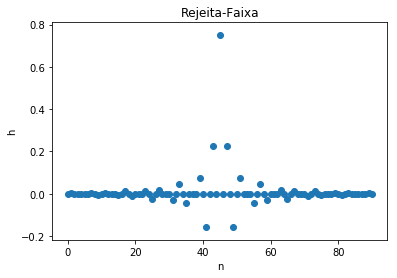

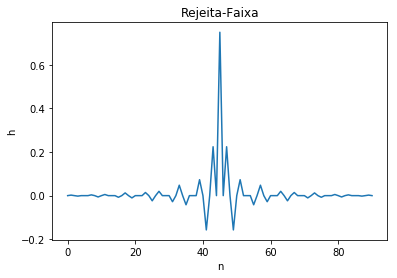

In [257]:
plt.figure(1)
plt.title("Rejeita-Faixa")
plt.xlabel("n")
plt.ylabel("h")
plt.scatter(n,h)
plt.show()

plt.figure(2)
plt.title("Rejeita-Faixa")
plt.xlabel("n")
plt.ylabel("h")
plt.plot(n,h)
plt.show()

##No domínio da frequência...
Ok, filtro pronto! Vamos ver seu comportamento no domínio da frequência:

In [0]:
k = np.linspace(-1,1,num = N)
H = np.fft.fft(h)

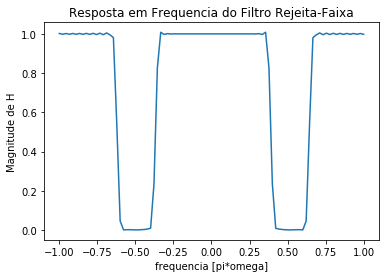

In [259]:
plt.title("Resposta em Frequencia do Filtro Rejeita-Faixa")
plt.xlabel("frequencia [pi*omega]")
plt.ylabel("Magnitude de H")
plt.plot(k,np.abs(H))

##Agora vamos aos áudios!

Já trabalhamos com áudio antes, como se pode ver [aqui](https://github.com/mtxslv/digitalprocessingsimulations/blob/master/FFTconvolution.ipynb). Vamos nos basear em alguns conceitos descritos no link acima, então, qualquer dúvida, só [ir lá](https://github.com/mtxslv/digitalprocessingsimulations/blob/master/FFTconvolution.ipynb) pra entender.

In [0]:
# Algumas importações
from IPython.display import Audio
from scipy.io import wavfile

In [261]:
#PERMISSÃO PRA USAR ARQUIVOS

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#DESCOBRINDO A TAXA DE AMOSTRAGEM E O ARQUIVO EM SI

from scipy.io import wavfile
fs, data = wavfile.read('/content/drive/My Drive/Colab Notebooks/Project_Files/audio2pds.wav')# fs = 8000, data.shape = (48640,)

In [0]:
t = np.linspace(0,6, data.shape[0]) # amostras de tempo pro ruído
ruido = 9000*np.cos(2*np.pi*2000*t) #gerando ruído de 2kHz
audio_ruidoso = data + ruido # unindo ruído com o próprio áudio

In [264]:
# player
Audio(audio_ruidoso, rate = fs)

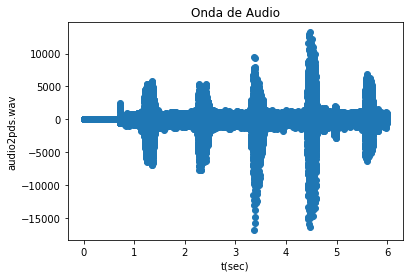

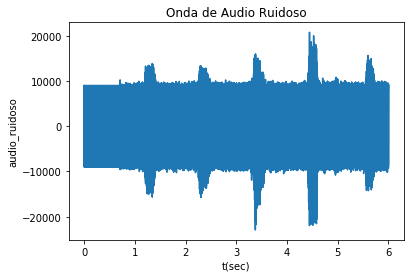

In [265]:
plt.figure(1)
plt.title("Onda de Audio")
plt.xlabel("t(sec)")
plt.ylabel("audio2pds.wav")
plt.scatter(t,data)
plt.show()

plt.figure(2)
plt.title("Onda de Audio Ruidoso")
plt.xlabel("t(sec)")
plt.ylabel("audio_ruidoso")
plt.plot(t,audio_ruidoso)
plt.show()

In [0]:
# E no domínio da frequência...

A = np.fft.fft(data)
A_R = np.fft.fft(audio_ruidoso)
k_audio = np.linspace(-1,1,num = data.shape[0])

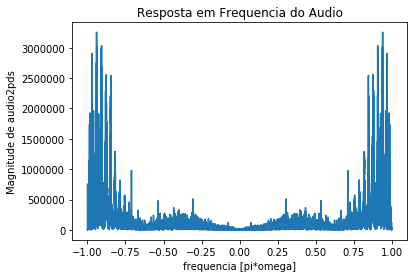

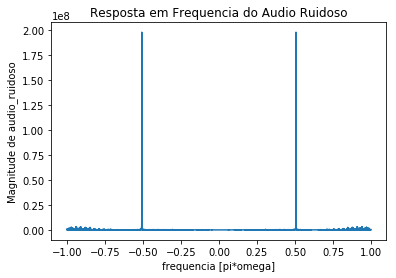

In [267]:
plt.figure(1)
plt.title("Resposta em Frequencia do Audio")
plt.xlabel("frequencia [pi*omega]")
plt.ylabel("Magnitude de audio2pds")
plt.plot(k_audio,np.abs(A))

plt.figure(2)
plt.title("Resposta em Frequencia do Audio Ruidoso")
plt.xlabel("frequencia [pi*omega]")
plt.ylabel("Magnitude de audio_ruidoso")
plt.plot(k_audio,np.abs(A_R))


In [0]:
#Filtrando o áudio...
audio_filtrado = np.convolve(audio_ruidoso, h)
t_conv = np.linspace(0,6,num = audio_filtrado.shape[0]) 

#Na frequência...
A_F = np.fft.fft(audio_filtrado)
k_filt = np.linspace(-1,1, num= A_F.shape[0])

In [276]:
# E como ficou?
Audio(audio_filtrado, rate = fs)

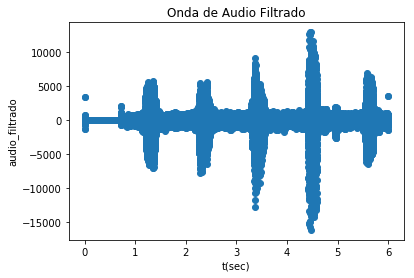

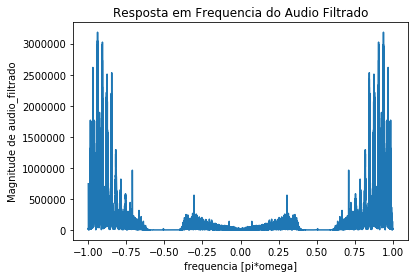

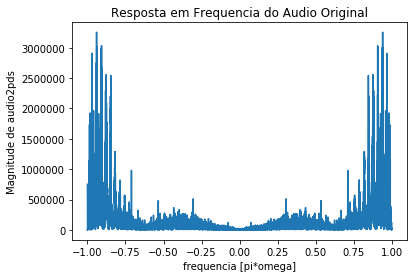

In [287]:
#Visualmente...

plt.figure(1)
plt.title("Onda de Audio Filtrado")
plt.xlabel("t(sec)")
plt.ylabel("audio_filtrado")
plt.scatter(t_conv,audio_filtrado)

plt.figure(2)
plt.title("Resposta em Frequencia do Audio Filtrado")
plt.xlabel("frequencia [pi*omega]")
plt.ylabel("Magnitude de audio_filtrado")
plt.plot(k_filt,np.abs(A_F))

plt.figure(3)
plt.title("Resposta em Frequencia do Audio Original")
plt.xlabel("frequencia [pi*omega]")
plt.ylabel("Magnitude de audio2pds")
plt.plot(k_audio,np.abs(A))

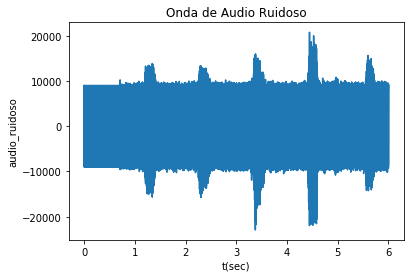

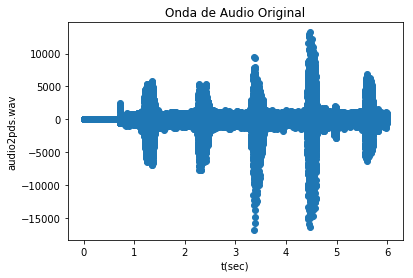

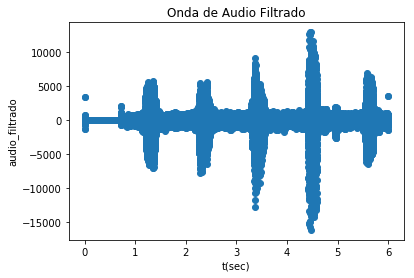

In [285]:
#Pra ter certeza...
plt.figure(1)
plt.title("Onda de Audio Ruidoso")
plt.xlabel("t(sec)")
plt.ylabel("audio_ruidoso")
plt.plot(t,audio_ruidoso)
plt.show()

plt.figure(2)
plt.title("Onda de Audio Original")
plt.xlabel("t(sec)")
plt.ylabel("audio2pds.wav")
plt.scatter(t,data)
plt.show()

plt.figure(3)
plt.title("Onda de Audio Filtrado")
plt.xlabel("t(sec)")
plt.ylabel("audio_filtrado")
plt.scatter(t_conv,audio_filtrado)